## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

### Инструкция по выполнению проекта

1. Загрузите данные и выполните их ресемплирование по одному часу.
2. Проанализируйте данные.
3. Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.
4. Проверьте данные на тестовой выборке и сделайте выводы.

### Описание данных

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце '*num_orders*' (от англ. *number of orders*, «число заказов»).

# 1. Подготовка

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy import stats as st
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler 
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

Установим в качестве индекса дату, и преобразуем ее к нужному типу. Выполним ресемплирование по одному часу.

In [2]:
df = pd.read_csv('/datasets/taxi.csv',index_col=[0],parse_dates=[0])
df.sort_index(inplace=True)
df = df.resample('1H').sum()

# 2. Анализ

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
num_orders    4416 non-null int64
dtypes: int64(1)
memory usage: 69.0 KB


In [4]:
df.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


Ежечасное количество заказов колеблется от 0 до 462. Рассмотрим графики распределений в зависимости от месяца, дня недели, и часа.

In [5]:
def make_features(data):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour

make_features(df)

In [6]:
df

,num_orders,year,month,day,dayofweek,hour
datetime,,,,,,
2018-03-01 00:00:00,124,2018,3,1,3,0
2018-03-01 01:00:00,85,2018,3,1,3,1
2018-03-01 02:00:00,71,2018,3,1,3,2
2018-03-01 03:00:00,66,2018,3,1,3,3
2018-03-01 04:00:00,43,2018,3,1,3,4
...,...,...,...,...,...,...
2018-08-31 19:00:00,136,2018,8,31,4,19
2018-08-31 20:00:00,154,2018,8,31,4,20
2018-08-31 21:00:00,159,2018,8,31,4,21


Text(0.5, 1.0, 'Ежечасное количество заказов')

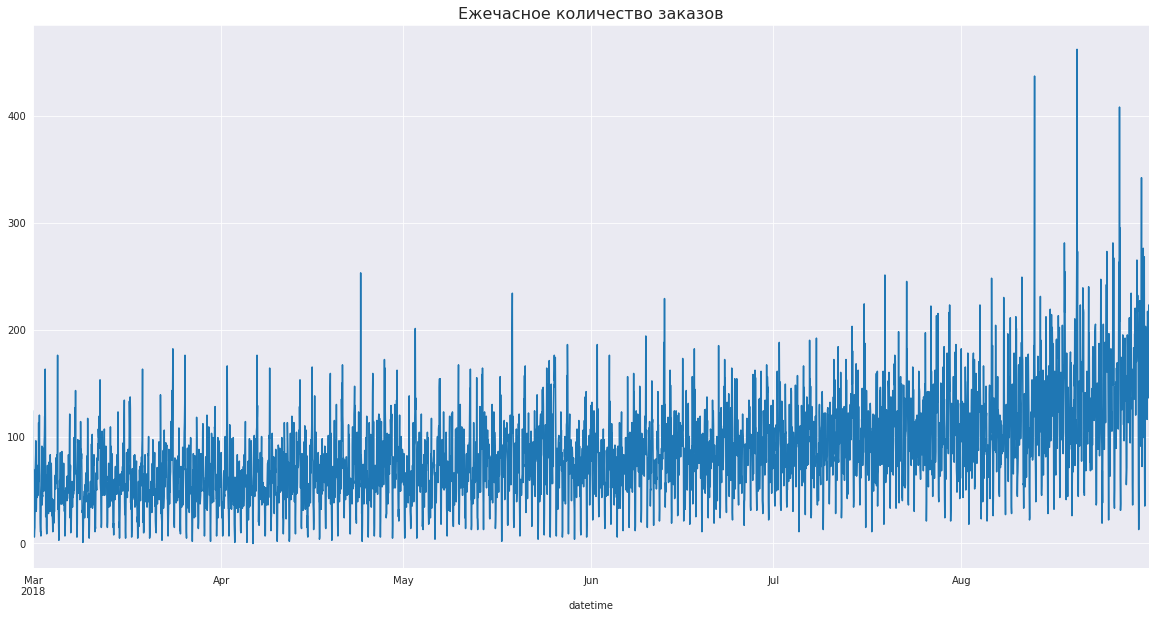

In [7]:
plt.figure(figsize=(20,10))
df['num_orders'].plot()
plt.title('Ежечасное количество заказов', fontsize=16)



Видно, что ежечасное количество постепенно растет - количество часов НЕ близких к нулю заказов. Стоит также отметить, что виды на всем промежутке имеются выбросы данных, но наиболее очевидны 4 пика в августе. Удалять их конечно же не надо, поскольку они могу быть вызваны каким-либо всплеском на услуги (например происходили какие-либо масштабные мероприятие в городе).

Text(0.5, 1.0, 'Ежедневное количество заказов')

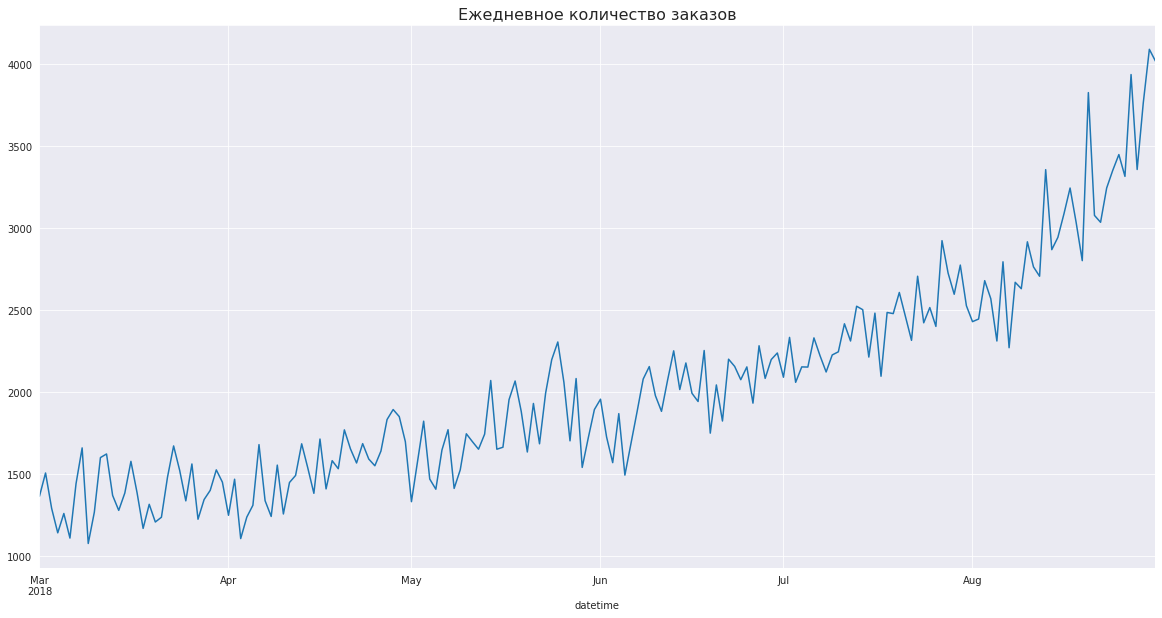

In [8]:
plt.figure(figsize=(20,10))
df['num_orders'].resample('1D').sum().plot()
plt.title('Ежедневное количество заказов', fontsize=16)

На графике выше виден ежедневый рост заказов в сервисе. 

Text(0.5, 1.0, 'Помесячное количество заказов')

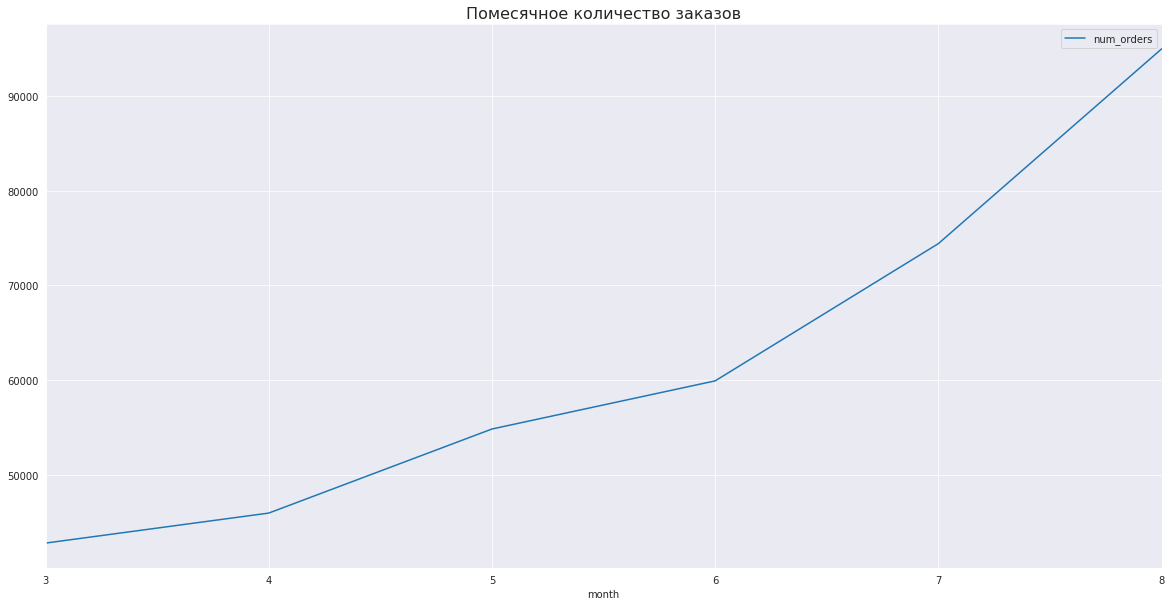

In [9]:
df.groupby('month').agg({'num_orders':'sum'}).plot(figsize=(20,10))
plt.title('Помесячное количество заказов', fontsize=16)

Text(0.5, 1.0, 'Ежедневное количество заказов')

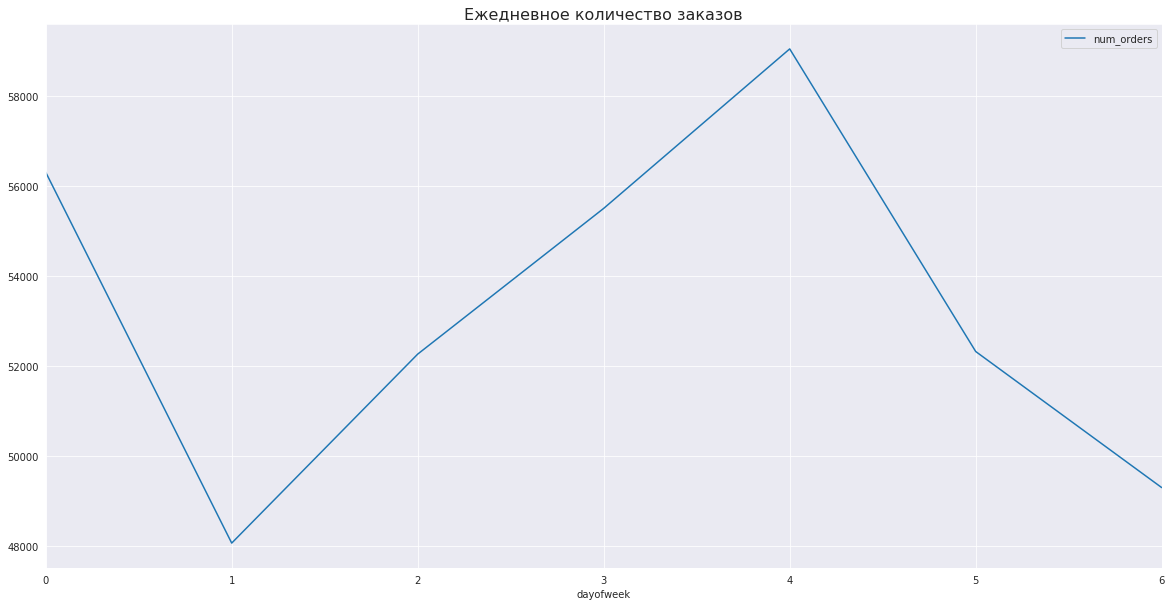

In [10]:
df.groupby('dayofweek').agg({'num_orders':'sum'}).plot(figsize=(20,10))
plt.title('Ежедневное количество заказов', fontsize=16)

Если рассматривать, в какие дни чаще всего обращаются пользователи, то видно странное падение спроса по вторник. Со вторника по пятницу идет рост заказов, который снижается в выходные. Рассмотрим более подробно, характерно ли это для каждого месяца.

Text(0.5, 1.0, 'Количество заказов в зависимости от дня недели (помесячно)')

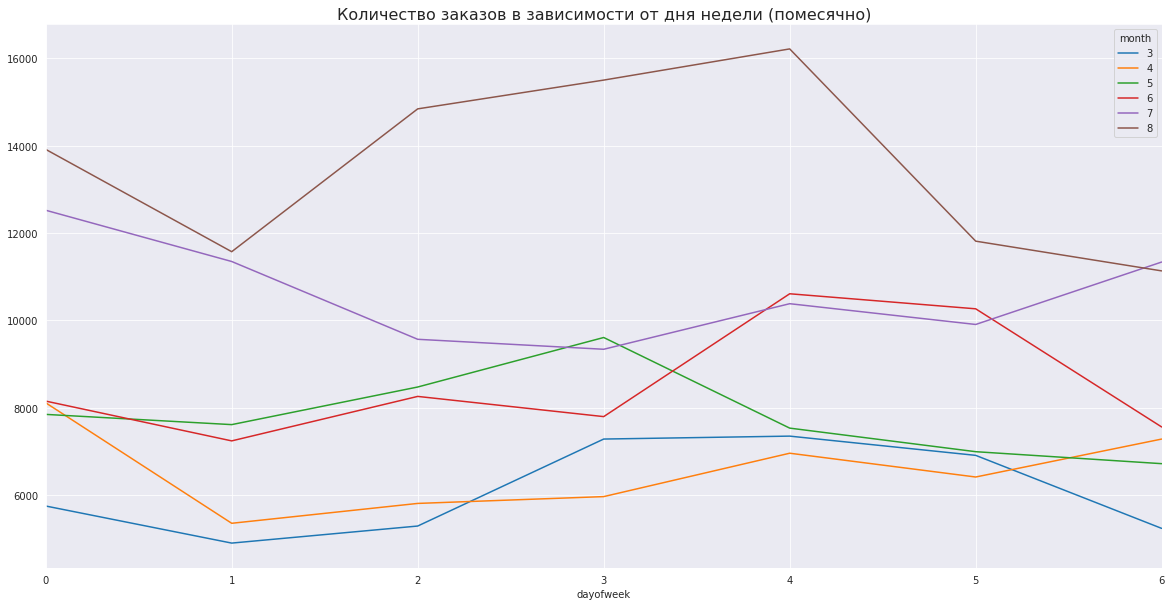

In [11]:
fig, ax = plt.subplots(figsize=(20,10))
ax.set_xticks(df['dayofweek'].unique())
df.groupby(["dayofweek", "month"]).sum()['num_orders'].unstack().plot(ax=ax)
plt.title('Количество заказов в зависимости от дня недели (помесячно)', fontsize=16)

Действительно, во всех месяцах кроме мая, видно падения спроса во вторник. 

Text(0.5, 1.0, 'Почасовое количество заказов')

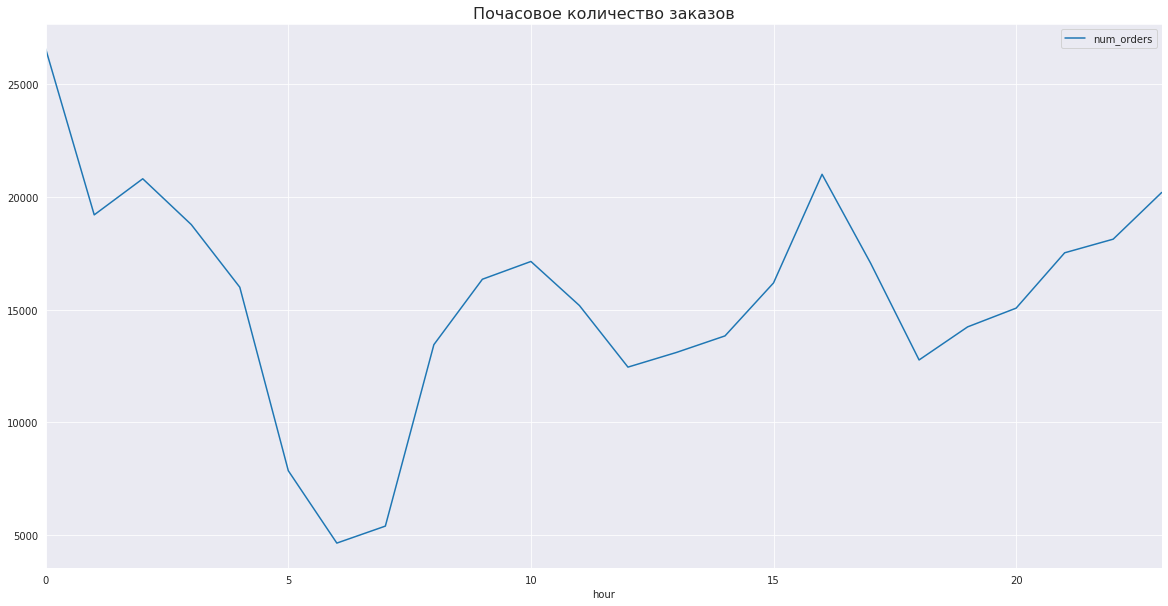

In [12]:
df.groupby('hour').agg({'num_orders':'sum'}).plot(figsize=(20,10))
plt.title('Почасовое количество заказов', fontsize=16)

Рост спроса на услуги начинается с 7 утра и до 10. Потом происходит небольшое падение спроса до 12 часов, и начиная с обеда вновь спрос начинает расти.

Text(0.5, 1.0, 'Количество заказов в зависимости от часа и дня недели')

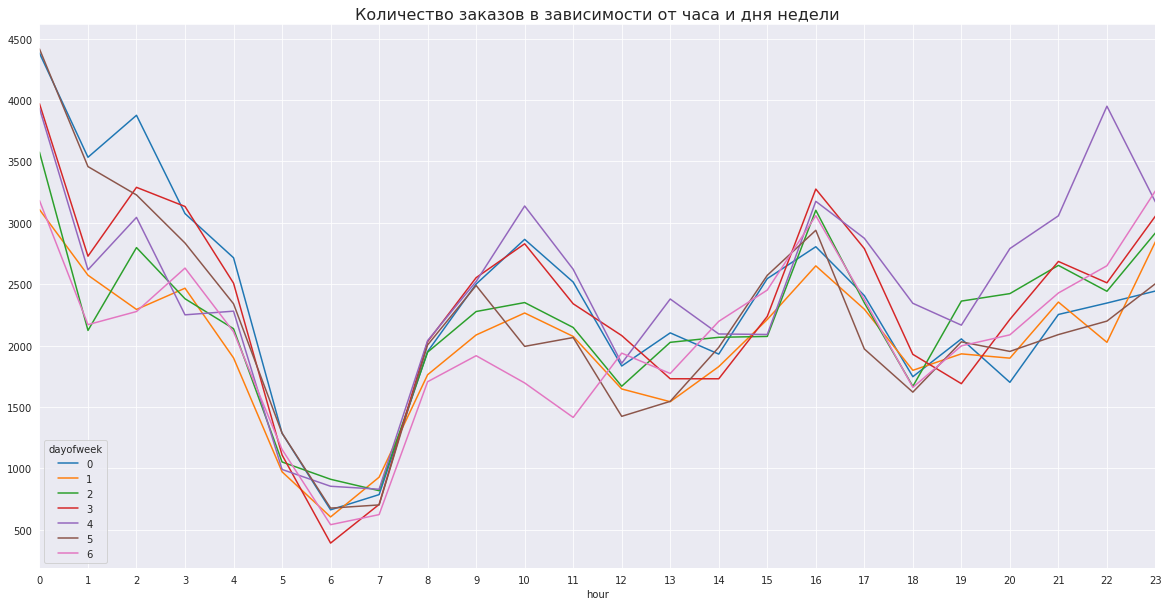

In [13]:
fig, ax = plt.subplots(figsize=(20,10))
ax.set_xticks(df['hour'].unique())
df.groupby(["hour", "dayofweek"]).sum()['num_orders'].unstack().plot(ax=ax)
plt.title('Количество заказов в зависимости от часа и дня недели', fontsize=16)

<p>Видно, что по пятницам в вечернее время повышенный спрос:)</p>
<p>Также заметен рост спроса в понедельник в 2 часа ночи. Не знаю как его объяснить.</p>

    

# 3. Обучение

Обучим LinearRegression, DecisionTreeRegressor, RandomForestRegressor, LGBMRegressor, CatBoostRegressor со стандартными гиперпараметрами. Результаты все сведем в единую таблицу, и дальше настроим гиперпарамтеры на ней. 

In [14]:
def make_mean(df, max_lag,rolling_mean_size):
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    train, test = train_test_split(df, shuffle=False, test_size=0.1)
    train = train.dropna()
    target_train = train['num_orders']
    features_train = train.drop(['num_orders'], axis=1)

    target_test = test['num_orders']
    features_test = test.drop(['num_orders'], axis=1)
    return target_train, features_train, target_test, features_test

In [15]:
target_train, features_train, target_test, features_test = make_mean(df,10,10)

In [16]:
res = []

In [17]:
def model(model_name):
    model = model_name
    model.fit(features_train,target_train) 
    

    predicted_test = model.predict(features_test)
    
    print('Среднее прогнозируемое =',predicted_test.mean())
    print('Среднее фактическое =',target_test.mean())
    print('RMSE =',mean_squared_error(target_test, predicted_test)**0.5)
    
    res.append({'Модель': model, 
                'Среднее фактическое': target_test.mean(), 
                'Среднее прогнозируемое': predicted_test.mean(), 
                'RMSE': (mean_squared_error(target_test, predicted_test)**0.5)})
    return res

In [18]:
model_lr = model(LinearRegression())

Среднее прогнозируемое = 121.585127986604
Среднее фактическое = 139.55656108597285
RMSE = 53.45464385673255


In [19]:
model_dtr = model(DecisionTreeRegressor(random_state=12345))

Среднее прогнозируемое = 128.11764705882354
Среднее фактическое = 139.55656108597285
RMSE = 57.01019992885134


In [20]:
model_rfr = model(RandomForestRegressor(n_estimators=100, random_state=12345))

Среднее прогнозируемое = 123.63459276018101
Среднее фактическое = 139.55656108597285
RMSE = 44.00707243910498


In [21]:
model_LightBLM = model(LGBMRegressor(random_state=12345))

Среднее прогнозируемое = 124.65484669175041
Среднее фактическое = 139.55656108597285
RMSE = 42.46268363530078


<div class="alert alert-success">
    
**Комментарий ревьюера**
    
Очень хорошо, что рассматриваешь несколько моделей)
</div>

In [22]:
model_cbr = model(CatBoostRegressor(random_state=12345))

0:	learn: 38.1167978	total: 49.2ms	remaining: 49.1s
1:	learn: 37.6172536	total: 51ms	remaining: 25.4s
2:	learn: 37.1217792	total: 52.5ms	remaining: 17.4s
3:	learn: 36.6684090	total: 54.1ms	remaining: 13.5s
4:	learn: 36.2051525	total: 60.8ms	remaining: 12.1s
5:	learn: 35.7471276	total: 67.7ms	remaining: 11.2s
6:	learn: 35.2970846	total: 135ms	remaining: 19.2s
7:	learn: 34.9057411	total: 137ms	remaining: 17s
8:	learn: 34.4999049	total: 139ms	remaining: 15.4s
9:	learn: 34.1744383	total: 141ms	remaining: 14s
10:	learn: 33.8022937	total: 143ms	remaining: 12.8s
11:	learn: 33.4293802	total: 150ms	remaining: 12.3s
12:	learn: 33.0645124	total: 233ms	remaining: 17.7s
13:	learn: 32.7389138	total: 234ms	remaining: 16.5s
14:	learn: 32.3899415	total: 236ms	remaining: 15.5s
15:	learn: 32.0574056	total: 238ms	remaining: 14.6s
16:	learn: 31.7937043	total: 240ms	remaining: 13.9s
17:	learn: 31.5021956	total: 247ms	remaining: 13.5s
18:	learn: 31.2327167	total: 331ms	remaining: 17.1s
19:	learn: 30.9330016	

In [23]:
res = pd.DataFrame(res)
res['Модель']=['LinearRegression','DecisionTreeRegressor','RandomForestRegressor','LGBMRegressor','CatBoostRegressor']

In [24]:
res.style.highlight_min(color = 'lightgreen', axis = 0)

,Модель,Среднее фактическое,Среднее прогнозируемое,RMSE
0,LinearRegression,139.557,121.585,53.4546
1,DecisionTreeRegressor,139.557,128.118,57.0102
2,RandomForestRegressor,139.557,123.635,44.0071
3,LGBMRegressor,139.557,124.655,42.4627
4,CatBoostRegressor,139.557,123.12,43.2666


Наилучший показатель показала модель LGBMRegressor. Значение RMSE - 42.4627. Постараемся улучшить ее показатели. 

In [25]:
def RMSE(target, predictions):
    rmse = mean_squared_error(target, predictions)**0.5
    return rmse
RMSE_score = make_scorer(RMSE, greater_is_better=True )

In [26]:
num_leaves = [31]

n_estimators = [100, 300, 500]

max_depth = [-1, 5]

min_child_samples = [20]

learning_rate = [0.1, 0.15]

hyperparameter_grid = {
    'n_estimators': n_estimators,
    'max_depth': max_depth,
    'min_child_samples': min_child_samples,
    'learning_rate': learning_rate,
    'num_leaves': num_leaves}


model = LGBMRegressor(random_state = 42)


random_cv = GridSearchCV(estimator=model,
    param_grid=hyperparameter_grid,
    cv=2, 
    scoring = RMSE_score,
    n_jobs = -1, verbose = 1, 
    return_train_score = True)


random_cv.fit(features_train,target_train) 

Fitting 2 folds for each of 12 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:   46.5s finished


GridSearchCV(cv=2, error_score='raise-deprecating',
             estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                     colsample_bytree=1.0,
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=-1, min_child_samples=20,
                                     min_child_weight=0.001, min_split_gain=0.0,
                                     n_estimators=100, n_jobs=-1, num_leaves=31,
                                     objective=None, random_state=42,
                                     reg_alpha=0.0, reg_lambda=0.0, silent=True,
                                     subsample=1.0, subsample_for_bin=200000,
                                     subsample_freq=0),
             iid='warn', n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.15], 'max_depth': [-1, 5],
                         'min_child_samples': [20],
                         'n_estimators': [100

In [27]:
predicted_test = random_cv.predict(features_test)
print(mean_squared_error(target_test, predicted_test)**0.5)

42.43341459158054


In [28]:
random_cv.best_params_

{'learning_rate': 0.1,
 'max_depth': 5,
 'min_child_samples': 20,
 'n_estimators': 500,
 'num_leaves': 31}

Нам удалось улучшить показатель с 42.462 до 42.433 Данные показатель выполняются при количестве деревьев равном 500, скорости обучения 0.1. 

In [29]:
final_results = pd.DataFrame(random_cv.cv_results_)
final_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_min_child_samples,param_n_estimators,param_num_leaves,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,mean_train_score,std_train_score
0,0.863611,0.041155,0.006424,0.000051,0.1,-1,20,100,31,"{'learning_rate': 0.1, 'max_depth': -1, 'min_c...",25.350550,30.876745,28.113648,2.763098,8,11.888559,8.688274,10.288416,1.600143
1,2.300378,0.104618,0.093948,0.000237,0.1,-1,20,300,31,"{'learning_rate': 0.1, 'max_depth': -1, 'min_c...",25.611948,30.936927,28.274437,2.662489,7,5.118524,3.035389,4.076957,1.041568
2,3.994038,0.202646,0.096929,0.002299,0.1,-1,20,500,31,"{'learning_rate': 0.1, 'max_depth': -1, 'min_c...",25.815291,30.972565,28.393928,2.578637,5,2.649731,1.230953,1.940342,0.709389
3,0.404292,0.000473,0.006081,0.000158,0.1,5,20,100,31,"{'learning_rate': 0.1, 'max_depth': 5, 'min_ch...",25.295798,30.432636,27.864217,2.568419,11,16.187602,12.723480,14.455541,1.732061
4,1.248351,0.053712,0.094583,0.001257,0.1,5,20,300,31,"{'learning_rate': 0.1, 'max_depth': 5, 'min_ch...",26.360070,30.717921,28.538995,2.178926,3,10.097784,7.891473,8.994628,1.103155
5,1.845027,0.053083,0.095529,0.001989,0.1,5,20,500,31,"{'learning_rate': 0.1, 'max_depth': 5, 'min_ch...",26.747473,31.004507,28.875990,2.128517,1,6.737490,5.343558,6.040524,0.696966
6,0.847526,0.039919,0.049573,0.043412,0.15,-1,20,100,31,"{'learning_rate': 0.15, 'max_depth': -1, 'min_...",25.447447,30.680512,28.063980,2.616533,10,9.080934,6.544066,7.812500,1.268434
7,2.600390,0.492380,0.095897,0.001841,0.15,-1,20,300,31,"{'learning_rate': 0.15, 'max_depth': -1, 'min_...",25.943271,30.940117,28.441694,2.498423,4,3.031367,1.510835,2.271101,0.760266
8,4.353369,0.256368,0.145012,0.043430,0.15,-1,20,500,31,"{'learning_rate': 0.15, 'max_depth': -1, 'min_...",26.144267,30.966461,28.555364,2.411097,2,1.198789,0.432547,0.815668,0.383121
9,0.397724,0.000534,0.049619,0.043807,0.15,5,20,100,31,"{'learning_rate': 0.15, 'max_depth': 5, 'min_c...",24.683355,30.361880,27.522618,2.839262,12,14.518110,10.728422,12.623266,1.894844


# Вывод
<p>В процессе анализа данных были выявлены такие факторы, как:</p>
<ul>
<li>постепенный ежемесячный рост заказов </li>
<li>падение спроса на услуги такси по вторникам</li>
<li>наибольший спрос на такси в 16 и 00 часов</li>
</ul>
<p>Для прогнозирования спроса на следующий час можно использовать модель LGBMRegressor. В результате тестирования показатель RMSE составил 42.333</p>